### Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images.
* Apply a color transform and append binned color features, as well as histograms of color.
* Create a feature vector from concatenating HOG, binned color and histogram of color vectors.
* Normalize the above features and randomize a selection for training and testing.
* Train a classifier Linear SVM classifier with normalized feature vectors. 
* Implement a sliding-window technique and apply the trained classifier on the windows to search for vehicles in images.
* Run the above pipeline on a video stream.
* To reduce false positives, create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
# Import required libraries
import numpy as np
import math
import cv2
import glob
import random
import matplotlib.pyplot as plt
from skimage.feature import hog
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
import time
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC, SVC
import pickle
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.model_selection import GridSearchCV
from numpy.random import random_integers

%matplotlib inline

C:\Users\vinod_000\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Utility function for converting image format

This is a function for converting images from a source format to another format more appropriate for feature extraction.

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

### Histogram of Oriented Gradients (HOG)

Compute HOG feature vector. Optionally, return HOG image for visualization.

In [3]:
def compute_hog(img, orient, pix_per_cell, cell_per_block, vis=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=False,
                                  block_norm='L1')
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=False,
                       block_norm='L1')
        return features

### Spatial and color binned features

For a given image compute feature vectors by (a) binning colors spatially, as well as (b) creating a histogram of colors from each channel. 

In [4]:
# Define a function to compute binned spatial features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Create a feature vector by combining HOG and binned color vectors

Combine HOG, spatially binned and histogram of color features to form a single feature vector for a given image.

In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_for_image(img, spatial_size=(16, 16), hist_bins=32, \
                               hist_range=(0, 256), orient = 9, pix_per_cell = 8, \
                               cell_per_block = 2):
    # Create a list to append feature vectors to
    feature = []

    ctrans_tosearch = convert_color(img, conv='BGR2YCrCb')        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = compute_hog(ch1, orient, pix_per_cell, cell_per_block)
    hog2 = compute_hog(ch2, orient, pix_per_cell, cell_per_block)
    hog3 = compute_hog(ch3, orient, pix_per_cell, cell_per_block)
    
    hog_features = np.hstack((hog1.ravel(), hog2.ravel(), hog3.ravel()))
    spatial_features = bin_spatial(img, spatial_size)
    color_hist_features = color_hist(img, hist_bins, hist_range)
    feature = np.concatenate((hog_features, spatial_features, color_hist_features))
    return feature

### Read in training dataset

Read in the images from the training dataset, and classify them based on whether it is an image of a vehicle or not.

In [6]:
images = []
images = glob.glob(r'C:\Users\vinod_000\Documents\Udacity SDND\CarND-Vehicle-Detection-master\**vehicles\**\*.png', recursive=True)
vehicle_images = []
non_vehicle_images = []

for image in images:
    if 'non-vehicles' in image:
        non_vehicle_images.append(image)
    else:
        vehicle_images.append(image)

### Visualize HOG transform for a few examples

Visualize the HOG feature vector for a random selection of vehicle and non-vehicle images. After some experimentation I settled on the following parameters for best results in terms of good positive detection with fewest false detections.

* Using the YCrCb representation (experimented with BGR, HSV, LUV, YCrCb)
* Using pix_per_cell of 8 (experimented with 8 and 16)
* Cell per block of 2
* Number of orientation bins of 9 (experimented with 7, 8, 9, 10, 11)

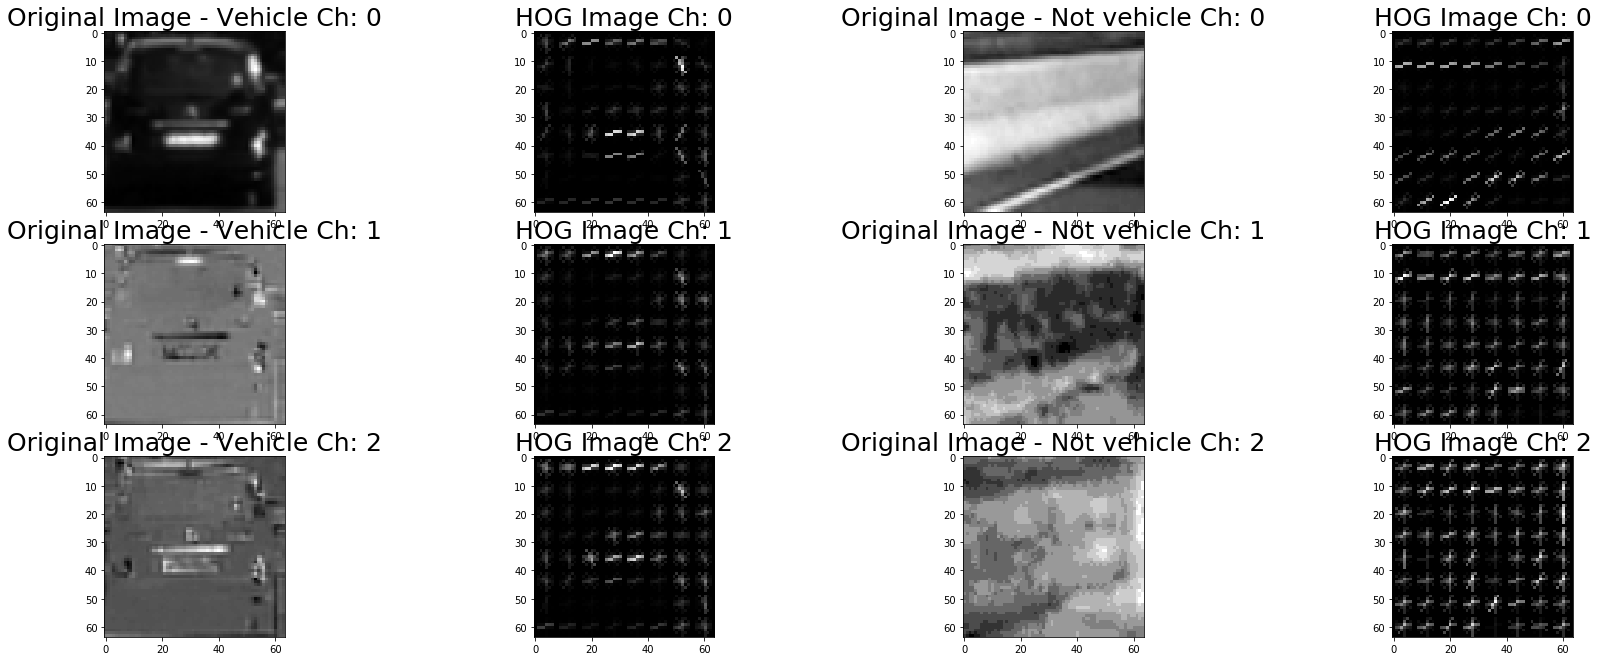

In [7]:
f, axarr = plt.subplots(3, 4, figsize=(24, 9))
f.tight_layout()

pix_per_cell = 8
cell_per_block = 2
orient = 9

img = cv2.imread(random.choice(vehicle_images))
img = convert_color(img, conv='BGR2YCrCb')
features, hog_image = compute_hog(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
axarr[0,0].imshow(img[:,:,0], cmap='gray')
axarr[0,0].set_title('Original Image - Vehicle Ch: 0', fontsize=25)
axarr[0,1].imshow(hog_image, cmap='gray')
axarr[0,1].set_title('HOG Image Ch: 0', fontsize=25)
features, hog_image = compute_hog(img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
axarr[1,0].imshow(img[:,:,1], cmap='gray')
axarr[1,0].set_title('Original Image - Vehicle Ch: 1', fontsize=25)
axarr[1,1].imshow(hog_image, cmap='gray')
axarr[1,1].set_title('HOG Image Ch: 1', fontsize=25)
features, hog_image = compute_hog(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
axarr[2,0].imshow(img[:,:,2], cmap='gray')
axarr[2,0].set_title('Original Image - Vehicle Ch: 2', fontsize=25)
axarr[2,1].imshow(hog_image, cmap='gray')
axarr[2,1].set_title('HOG Image Ch: 2', fontsize=25)

img = cv2.imread(random.choice(non_vehicle_images))
img = convert_color(img, conv='BGR2YCrCb')
features, hog_image = compute_hog(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
axarr[0,2].imshow(img[:,:,0], cmap='gray')
axarr[0,2].set_title('Original Image - Not vehicle Ch: 0', fontsize=25)
axarr[0,3].imshow(hog_image, cmap='gray')
axarr[0,3].set_title('HOG Image Ch: 0', fontsize=25)
features, hog_image = compute_hog(img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
axarr[1,2].imshow(img[:,:,1], cmap='gray')
axarr[1,2].set_title('Original Image - Not vehicle Ch: 1', fontsize=25)
axarr[1,3].imshow(hog_image, cmap='gray')
axarr[1,3].set_title('HOG Image Ch: 1', fontsize=25)
featurs, hog_image = compute_hog(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
axarr[2,2].imshow(img[:,:,2], cmap='gray')
axarr[2,2].set_title('Original Image - Not vehicle Ch: 2', fontsize=25)
axarr[2,3].imshow(hog_image, cmap='gray')
axarr[2,3].set_title('HOG Image Ch: 2', fontsize=25)

plt.show()
plt.close(f)    # close the figure


### Noramlize and label training data

For each image in the training set create a label indicating whether this image is of a vehicle or not. Flip the image horizontally to get more training samples.

Also normalize the feature vector elements in each dimension.

In [ ]:
cars = []
notcars = []
images = list(set(images))
features = []
labels = []
for image in images:
    img = cv2.imread(image)
    img_flipped = cv2.flip(img,1)
    feature = extract_features_for_image(img)
    features.append(feature)
    feature = extract_features_for_image(img_flipped)
    features.append(feature)
    if 'non-vehicles' in image:
        labels.append(0)
        labels.append(0)
    else:
        labels.append(1)
        labels.append(1)

features = np.vstack(features).astype(np.float64)
features_scaler = StandardScaler().fit(features)
scaled_features = features_scaler.transform(features)

### Split training data into test and validation subsets

In [ ]:
y = np.hstack(labels)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, len(images))
features_train, features_test, labels_train, labels_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=rand_state)

### Cache the normalized training and test sets for faster iterations

In [ ]:
# Saving the objects:
with open('objs.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([features_train, features_test, labels_train, labels_test, features_scaler], f)

In [6]:
# Getting back the objects:
with open('objs.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    features_train, features_test, labels_train, labels_test, features_scaler = pickle.load(f)

### Train a Linear SVM on the train set and validate performance on test set

I experimented with both linear and rbf kernels before settling on linear kernels which offered better performance. I also used hard negative mining to reduce false positives. Performing 5 iterations of this process allowed the SVM to converge to a good model with few false positives, and high positive detection rate.

In [7]:
# Use a linear SVC
t=time.time()

# All of the parameters below are default parameters for linear SVC. They are simply specified in detail 
# to allow for qucker experimentation with changing parameters.
svc = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
svc.fit(features_train, labels_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(features_test, labels_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(features_test[0:n_predict]))
print('For these',n_predict, 'labels: ', labels_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9945
My SVC predicts:  [0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1]
For these 100 labels:  [0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1]
0.01647 Seconds to predict 100 labels with SVC


### Utility functions for applying sliding window technique

Define functions for 

* adding 'heat' metrics to each pixel to estimate reliability of vehicle detection
* applying thresholding to reject low-confidence detections
* overlaying multi-colored boxes on our image where vehicles are detected
* drawing labeled boxes after thresholding

In [8]:
# Utility function to track how many overlapping boxes include any pixel
# The more overlapping boxes covering a pixel, the more lixely the pixel is
# part of a vehicle image
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += np.int(255.0/28.0) #1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# To reduce false detection of vehicles, apply a threshold to filter
# out 'weak' detections
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Define a function to draw bounding boxes in different colors
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    color_list = [(0, 0, 255),(0, 255, 255),(255, 0, 255),(255, 255, 255),(255, 0, 0),(255, 255, 0),(0, 255, 0),\
                  (128, 128, 128),(0, 0, 128),(0, 0, 0),(128, 0, 0),(128, 128, 0),(0, 128, 128),(0, 0, 0)]
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], random.choice(color_list), thick)
    # Return the image copy with boxes drawn
    return imcopy

# Utility funtion for drawing labelled boxes. Require boxes to have a certain
# minimum height and width to filter out boxes which are too small to represent
# a vehicle.
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzerox) - np.min(nonzerox) >= 64) and \
            (np.max(nonzeroy) - np.min(nonzeroy) >= 64)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

### Sliding window analysis

This function is based on examples from the video lectures. It performs the following steps:

* Crop the image to eliminate false detections in the upper half of the image, and also at the very bottom of the image
* Convert the image to YCrCb space which yielded the best performance, and scale the image by the scaling factor
* Compute HOG feature for the entire cropped image
* Apply a sliding window across the cropped image. For each window, extract the feature vector comprised of HOG features, spatially binned colors and histogram of colors.
* Scale the feature vector and apply the SVM classifier to the scaled feature vector.
* If a vehicle is detected, append this detected window to the list of all such windows.
* Also save the image to manually scan for false positives later. We try to filter out false positives using hard negative mining.

In [16]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def search_windows(img, ystart, ystop, scale, svc, X_scaler, \
                   orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step):
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='BGR2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)
    nyblocks = (ch1.shape[0] // pix_per_cell) 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1 #+ 1 - cell_per_block
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = compute_hog(ch1, orient, pix_per_cell, cell_per_block)
    hog2 = compute_hog(ch2, orient, pix_per_cell, cell_per_block)
    hog3 = compute_hog(ch3, orient, pix_per_cell, cell_per_block)

    on_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((hog_features,spatial_features, hist_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                out_img = cv2.resize(draw_img[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw],\
                                     (64,64))
                # Save framed image whenever a vehicle is detected. This is used for hard negative mining
                # for any false detections
                filename = 'captures\\'+str(random_integers(1,1000000))+'.png'
                #cv2.imwrite(filename,out_img)
                
    return on_windows

### Apply sliding windows of different scales for different regions in the image

As explained in the video lectures, for efficiency use knowledge of how large the vehicle can be in different sections of the image.

In [17]:
def sliding_window(image):

    global convert
    global previous_hot_windows
    global previous_previous_hot_windows
    global previous_previous_previous_hot_windows
    
    if (convert):
        image = convert_color(image, conv='RGB2BGR')

    ystart = [400, 400, 400, 400, 400, 400, 400]
    ystop = [550, 550, 550, 550, 600, 650, 700]
    scales = [1, 1.25, 1.5, 1.75, 2, 2.5, 3]
    cells_per_step = [2, 2, 2, 2, 2, 2, 2]

    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    hot_windows = []
    index = 0
    for scale in scales:
        hot_window = []
        hot_window = search_windows(image, ystart[index], ystop[index], \
                                    scale, svc, features_scaler, orient, \
                                    pix_per_cell, cell_per_block, spatial_size, \
                                    hist_bins, cells_per_step[index])
        hot_windows = hot_windows + hot_window       
        index = index + 1
    
    hot_windows_total = previous_hot_windows + hot_windows + previous_previous_hot_windows + \
                        previous_previous_previous_hot_windows
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows_total)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    # Uncomment line 46 for drawing labeled boxes
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # Uncomment line 49 for drawing multi-colored boxes for all windows where a
    # vehicle is detected
    draw_img = draw_boxes(image,hot_windows)
    
    # Uncomment lines 53-56 for getting heat images
    #draw_img = np.zeros_like(image)
    #draw_img[...,2] = heatmap
    #draw_img[...,1] = np.zeros_like(image[:,:,0])
    #draw_img[...,0] = np.zeros_like(image[:,:,0])
    
    previous_previous_previous_hot_windows = previous_previous_hot_windows
    previous_previous_hot_windows = previous_hot_windows
    previous_hot_windows = hot_windows
    
    # Ww have to apply a conversion for mp4 images
    if (convert):
        draw_img = convert_color(draw_img, conv='BGR2RGB')

    return draw_img

6


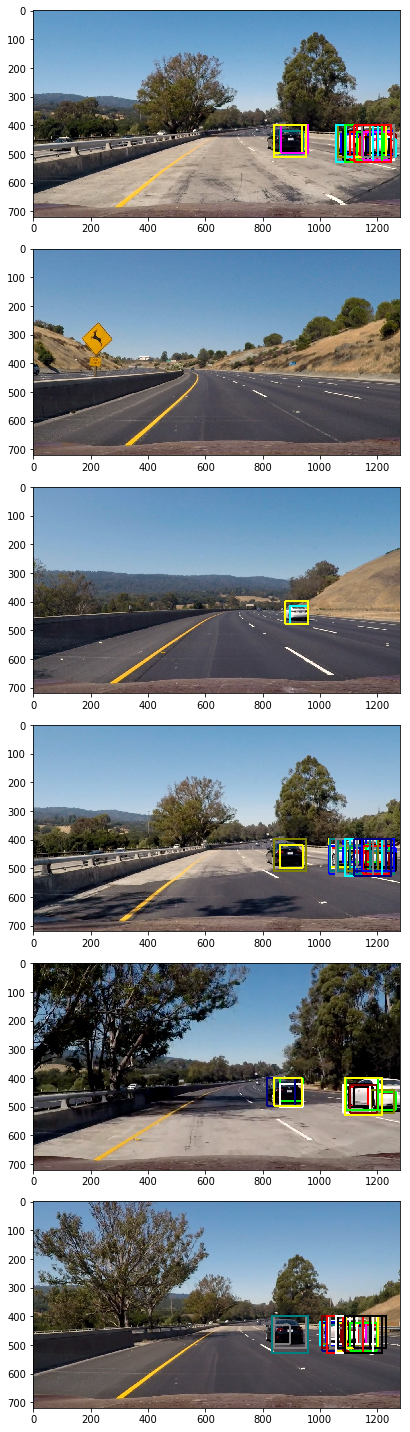

In [19]:
images = []
images = glob.glob('test_images/test*.jpg')

print(len(images))
f, axarr = plt.subplots(len(images), 1, figsize=(50, 20))
f.tight_layout()

i = 0
for img in images:
    previous_hot_windows = []
    previous_previous_hot_windows = []
    previous_previous_previous_hot_windows = []
    convert = 0
    image = cv2.imread(img)
    draw_img = sliding_window(image)
    filename = 'captures\\'+str(random_integers(1,1000000))+'.png'
    cv2.imwrite(filename,draw_img)
    draw_img = convert_color(draw_img, conv='BGR2RGB')
    axarr[i].imshow(draw_img)
    i = i + 1


In [14]:
# Edit this function to create your own pipeline.
previous_hot_windows = []
previous_previous_hot_windows = []
previous_previous_previous_hot_windows = []
convert = 1

#output = 'test_video_output.mp4'
#clip1 = VideoFileClip("test_video.mp4")
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

out_clip = clip1.fl_image(sliding_window) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████▉| 1260/1261 [28:07<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 28min 7s



### Histogram of Oriented Gradients (HOG)

####1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

####2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

####3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

###Sliding Window Search

####1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

####2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]
---

### Video Implementation

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


####2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]



---

###Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  



### Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

###Histogram of Oriented Gradients (HOG)

####1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

####2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

####3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

###Sliding Window Search

####1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

####2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]
---

### Video Implementation

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video.mp4)


####2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]



---

###Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

